# Завдання на використання SQL в Python

1.Встановіть бібліотеку `mysql-connector-python` через pip aбо через conda.

In [1]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 22.4 MB/s eta 0:00:00


2.В змінній `con` створіть підключення до бази даних employees за аналогією того, як це робилось в лекції:

In [38]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime

In [39]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

3.Виберіть максимальну і мінімальну дати найму співробітників використовуючи `con.cursor()`. Аби отримати результати в кінці, виконайте `cursor.fetchall()`.

In [40]:
cursor = con.cursor()

In [41]:
cursor.execute("SELECT MAX(hire_date), MIN(hire_date) FROM employees")
cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

Очікуваний результат:  
    `[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]`

4.Давайте зберемо інформацію про останню ЗП кожного співробіткника в базі. З використанням `con.cursor()` виберіть з таблиці `salaries` для кожного співробітника його номер, останню в базі даних (тобто ту, що відповідає найновішій `to_date`) ЗП, та значення `from_date`, `to_date` для цієї ЗП.

Результати запишіть у pandas DataFrame, який збережіть у змінну `res`. Як взяти з курсора назви колонок - вже наведено. На екран виведіть назви колонок в змінній `res`, розмір цього датафрейму та перші 3 записи в ньому.

УВАГА! Зверніть увагу, що ЗП може оновлюватись протягом одного дня, тобто є випадки, коли апдейт ЗП був в певний день, скажімо 2001-01-01 і потім стався ще один апдейт ЗП цьому співробітнику цього самого дня. Запит має це враховувати.
Також, теоретично ЗП може бути зменшена. Тож, брати дату з максимальною ЗП буде неправильно з точки зору бізнес логіки. Треба саме останнє історичне значення ЗП кожного співробітника.

In [42]:
import pandas as pd

In [43]:
cursor = con.cursor()

In [44]:
cursor.execute("""
    SELECT emp_no, salary, from_date, to_date
    FROM salaries s1
    WHERE (to_date, from_date) IN (
        SELECT to_date, MAX(from_date)
        FROM salaries s2
        WHERE s1.emp_no = s2.emp_no
        GROUP BY to_date, emp_no
    )
    AND to_date = (
        SELECT MAX(to_date)
        FROM salaries s3
        WHERE s1.emp_no = s3.emp_no
    );
""")
rows = cursor.fetchall()

In [45]:
field_names = [i[0] for i in cursor.description]

In [46]:
res = pd.DataFrame(rows, columns=field_names)
res.head(3)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


In [47]:
res.shape

(300024, 4)

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1lNvzbAebtkj3C2v-I5AE6HkMH8MTI1kA)

5.В утвореній вибірці в змінній `res` скільки значень `to_date` рівні `9999-01-01`, а скільки - ні? Увага! Для виконання цього завдання важливо розуміти, який тип даних у значень колонки `to_date`. Зʼясуйте це, і потім напишіть фільтр для виводу потрібного результату.

In [48]:
cursor.execute("SELECT to_date FROM salaries LIMIT 1;")
columns = cursor.description
for col in columns:
    print(f"Column: {col[0]}, Type: {col[1]}")
# Колонка to_date має тип 10, це означає, що її тип даних — DATE, і вона зберігає дату в форматі YYYY-MM-DD

Column: to_date, Type: 10


In [49]:
from datetime import date

target_date = date(9999, 1, 1)

count_equal = res[res['to_date'] == target_date].shape[0]
count_not_equal = res[res['to_date'] != target_date].shape[0]

print("Кількість значень to_date == 9999-01-01:", count_equal)
print("Кількість значень to_date != 9999-01-01:", count_not_equal)

Кількість значень to_date == 9999-01-01: 240124
Кількість значень to_date != 9999-01-01: 59900


6.Виведіть візуально розподіл (гістограму) зарплат співробітників, які досі працюють в компанії, використовуючи результат попереднього завдання. Співробітниками, які досі працюють в компанії вважаємо тих, в кого to_date має значення 9999-01-01. Обовʼязково підпишіть графік і вісі.

Ці три завдання - приклад, як нам може бути зручно витягнути дані з бази певним запитом, а потім використати витягнуту вибірку у Python для подальшого аналізу.

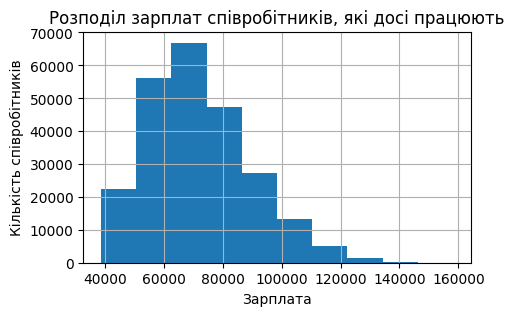

In [50]:
res = pd.DataFrame(res)
import matplotlib.pyplot as plt
# Фільтрація співробітників, які досі працюють
target_date = date(9999, 1, 1)
current_employees = res[res["to_date"] == target_date]

# Побудова гістограми зарплат
plt.figure(figsize=(5, 3))
plt.hist(current_employees["salary"])
plt.title("Розподіл зарплат співробітників, які досі працюють")
plt.xlabel("Зарплата")
plt.ylabel("Кількість співробітників")
plt.grid()
plt.show()

Очікуваний результат:

![](https://drive.google.com/uc?export=view&id=1j8MHLC1E0revbQLM9B0UJs6tVEgoWhmK)

НЕ ЗАБУВАЄМО ЗАКРИТИ ПІДКЛЮЧЕННЯ ДО БАЗИ :)

In [14]:
con.close()